# Etude d'un mouvement à force centrale
__But :__ obtenir des trajectoires d’un point matériel soumis à un champ de force centrale conservatif

## Position du problème
On se propose d'étudier l'expérience de Rutherford où des particules alpha (charge $+2e$) d'énergie cinétique $E_c$ bombardent des noyau d'or $Z = 79$ supposés fixes dans un référentiel galiléen. On peut supposer que chaque particule ne rencontre qu'un seul noyau d'or qui est responsable de sa déviation.

Dans la modélisation habituelle, les particules sont initialement à l'infini et l'interaction entre le noyau et la particule est coulombienne :

Nous allons :
* Etablir une condition sur la distance initiale pour pouvoir considérer que les particules sont initialement sur une trajectoire de diffusion.
* Déterminer et tracer la trajectoire des particules alpha pour plusieurs paramètres d'impact $b$ à énergie cinétique fixée.
* Déterminer l'angle de diffusion en fonction du paramètre d'impact $b$ et vérifier la cohérence avec la loi attendue.
* Simuler un bombardement homogène et vérifier que la loi sur la section efficace attendue est correcte.
* Etudier la dépendance de la précédente loi à l'énergie cinétique des particules alpha.

## Modélisation du problème.
On suppose la particules alpha initialement à une distance $r_i$ __suffisamment grande__ pour qu'elle puisse presque être considérée comme à l'infini (on ne peut pas la placer à l'infini pour une simulation numérique !). Le paramètre d'impact $b$ représenté sur la figure est supposé connu. Elle possède initialement une vitesse $v_0$ orientée comme sur le schéma.

![Conditions initiales](images/rutherford.png)

### Considération sur les unités
Comme dans le cas de l'étude de la vibration moléculaire, on va se placer dans un système d'unités évitant des puissances de 10 trop grandes. On va donc travailler avec comme unité de référence :
* la charge élémentaire devient $e = 1(UA)$
* la masse atomique devient $m = 1(UA)$
* la distance $r = 10^{-14} m$ (taille typique du noyau) devient $r = 1 (UA)$
* l'énergie $E = 1.6 \times 10^{-19} J$ (1eV) devient $E = 1(UA)$

Dans ces conditions, les données numériques utiles deviennent :
* Masse des particules alpha : $m = 4 (UA)$
* Energie cinétique initiale $E_{c0} = 5.3 \times 10^6 (UA)$ (cette valeur sera susceptible de changer ensuite).
* Constante ${e^2 \over 4 \pi \epsilon_0} = 1.4 \times 10^4 (UA)$
* un pas de temps de $h = 1(UA)$ correspondra à $1.0 \times 10^{-18} s$

### Mise en équation
Il s'agit d'un problème classique de force centrale coulombienne, la conservation du moment cinétique et le principe fondamental de la dynamique permettent de se ramener à un problème à trois inconnues :

$$
{\rm{d} \over \rm{d}t}
\begin{pmatrix}
\theta \\
r \\
\dot r
\end{pmatrix}(t)
=
\begin{pmatrix}
{bv_0 \over r(t)^2} \\
\dot r(t) \\
{b^2 v_0^2 \over r(t)^3} + {2Ze^2 \over 4 \pi \epsilon_0 m r(t)^2}
\end{pmatrix}
$$

### Schéma d'Euler
On utlisera directement la fonction native `odeint` de la bibliothèque `scipy.integrate`. Sa signature doit être adaptée pour tenir compte du moment cinétique qui va changer :

```
Ysol = odeint(F, Y0, t, args=(C,))
```

avec :
* `F(Y, t, C)` la fonction telle que $\frac{\rm{d}Y}{\rm{dt}}(t) = F(Y, t, C)$ et $Y = (\theta, r, \dot r)$. `F` doit renvoyer un vecteur. L'argument `C` sera la constante des aires $C = bv_0$. Elle apparaît dans `F` mais variera suivant les conditions initiales.
* `Y0` les conditions initiales (vecteur)
* `t` vecteur contenant l'ensemble des instants où l'on veut estimer la fonction `Y(t)`
* `args = (C,)` permettra de passer à la fonction `F` le troisième argument `C`. On y mettra donc la valeur de la constante des aires. __Attention, les parenthèse et la virgule sont obligatoire.__
* `Ysol` le tableau renvoyé qui contient les estimations des fonctions (ici $\theta(t), r(t), \dot r(t)$) aux instants du vecteur `t`



### Conditions initiales
Les conditions initiales ne sont pas directement $\theta, r, \dot r$ mais :

$$
\begin{pmatrix}
b \\
r(t=0) = r_i \\
Ec(t=0) = E_{c0}
\end{pmatrix}
$$

avec $v_0$ suivant $-\vec e_x$.

__Il faudra donc déterminer $\theta, r, \dot r$ à partir de ces contraintes avant de commencer l'intégration.__

Pour qu'on puisse considérer que la particules est à l'infini et proche de l'axe Ox, il faut deux conditions sur $r_i$:
* $r_i \gg r_{min}$ avec $r_{min}$ le rayon limite  à $t=0$ pour lequel la particule alpha est placée dans un état de diffusion.
* $r_i \gg b$

__On choisira donc $r_i = \max(1000 r_{min}, 1000 b)$.__

### Temps d'observation
En supposant $r_i$ suffisamment grand, le temps que mettra la particule pour atteindre à nouveau la distance $r_i$ dans un état de diffusion est de l'ordre de ${2r_i \over v_0}$. On pourra se servir de cette estimer pour choisir un pas de temps donnant __approximativement__ N points sur la trajectoire.

__Pour se donner un peu de marge on choisira un un durée totale de simulation égale ${4r_i \over v_0}$ et un nombre de points de simulation $N = 10000$.__

## Bibliothèques utiles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rd
from scipy.integrate import odeint

## Travail sur les conditions initiales

> __Exercice 1 :__
> 1. Trouver par le calcul une condition sur $ri$ pour que la particule alpha, possédant une énergie cinétique $E_{c0}$ soit dans un état de diffusion. On note $r_{min}$ la valeur minimale trouvée. Pour pouvoir négliger l'énergie potentielle et donc l'interaction à l'instant initiale, on prend $ri = 1000 r_{min}$ comme condition initiale.
> 2. En vous aidant de la figure et du calcul précédent, écrire une fonction `CI(b, Ec0)` qui prend comme argument les conditions initiales `b` et `Ec0` et qui renvoient les conditions initiales $\theta(t=0), r(t=0), \dot r(t=0)$ sous forme d'un vecteur numpy. _On considèrera que $b$ est de signe quelconque et que $v_0$ est positif pour un vecteur vitesse suivant $-\vec e_x$._

In [2]:
"""Données numériques globales"""
m = 4  # Masse des particules alpha
Z = 79
K = 1.44e4  # e^2/(4 pi Epsilon0)
K1 = 2 * Z * K

def CI(b, Ec0):
    """Calcul des conditions initiales pour un paramètre d'impact donné et une énergie cinétique donnée"""
    v0 = np.sqrt(2 * Ec0 / m)  # Vitesse initiale
    rmin = K1 / Ec0  # rmin
    k = 1000
    ri = max(k  * rmin, k * b)
    theta = np.arcsin(b / ri)
    rpoint = -v0 / np.cos(theta)
    return [theta, ri, rpoint]

## Détermination de la trajectoire

L'implémentation du schéma d'Euler sera ici un peut particulière : on ne va pas arrêter l'intégration à un temps fixé mais lorsque la particule aura atteint à nouveau la distance $r_i$. On pourra alors considérer qu'elle est à nouveau "à l'infini".

__Vous ne connaîtrez donc pas à l'avance la taille des ensembles de points `tk`(temps), `thetak`, `rk` et `rpointk`.__

> __Exercice 2 :__  
> 1. Ecrire la fonction `F(Y, t, C)` introduite dans le schéma d'Euler explicite. __Attention, Y est ici un vecteur à 3 coordonnées.__
> 3. Ecrire la fonction `deviation(b, Ec0, N)` qui doit, à partir du paramètre d'impact `b`, de l'énergie cinétique initiale `Ec0` et du nombre de points de calculs `N` :
>     * calculer les conditions initiales
>     * créer un vecteur `temps` contenant les instants où on veut estimer les coordonnées polaires.
>     * utiliser la fonction `odeint` pour réaliser l'intégration numérique
>     * renvoyer le veceur `temps` et le tableau du résultat de l'intégration
> 4. Ecrire une fonction `polçto_cart(r, theta)` qui prend comme arguments deux vecteurs `r` et `theta` correspondant à des coordonnées polaires et qui renvoie les vecteurs de coordonnées `x` et `y` cartésiennes associées.
> 5. Pour la valeur d'énergie cinétique donnée dans l'énoncé, déterminer puis tracer la trajectoire pour des paramètres d'impacts $b$ allant de 0.01 (inclus) à 1000 (inclus, 16 valeurs, on utilisera `logspace` pour répartir les valeurs sur une échelle logarithmique) et commenter l'allure des trajectoires et l'angle de déviation observé. _On choisira N = 10000 points._ Est-ce qu'on attend ?

_Indications utiles :_  
* Pour rappel, la signature est `logspace(start, stop, Np)` pour créer Np point entre $10^{start}$ et $10^{stop}$ inclus.

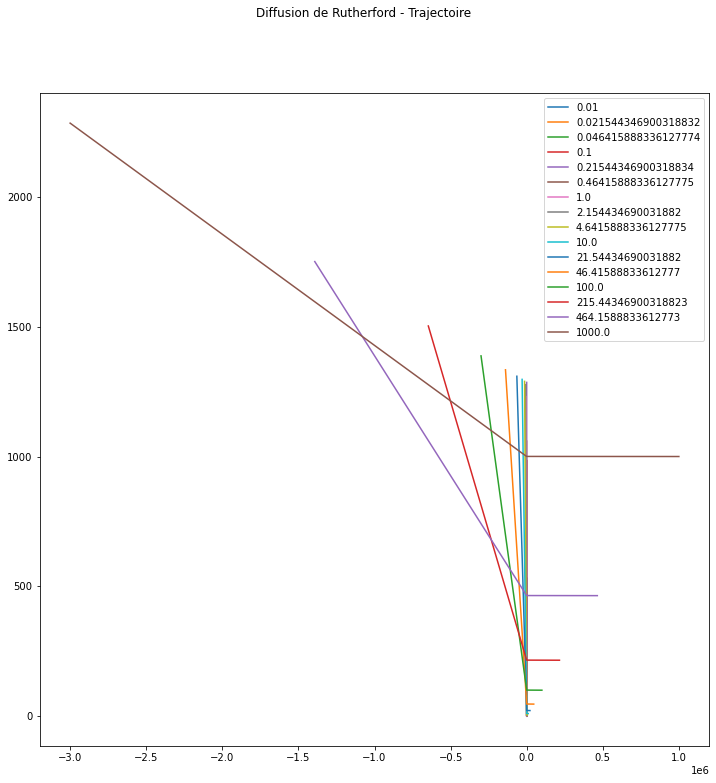

In [3]:
"""Note : On pourrait remplacer les variables b et v0 par une seule C = b * v0
C'est la constante des aires."""
def F(Y, t, C):
    """Fonction F pour le schéma d'Euler"""
    return np.array([C / Y[1] ** 2, Y[2], C ** 2 / Y[1] ** 3 + K1 / (m * Y[1]**2)])


def deviation(b, Ec0, N):
    Y0 = CI(b, Ec0)  # Condition initiales
    v0 = np.sqrt(2 * Ec0 / m)  # Vitesse initiale
    Caire = b * v0  # Constante des aires
    tf = 4 * Y0[1] / v0  # Temps final
    temps = np.linspace(0, tf, N)  # Vecteur des temps
    Y = odeint(F, Y0, temps, args=(Caire, ))  # Intégration numérique
    return temps, Y

def pol_to_cart(r, theta):
    return np.array([r * np.cos(theta), r * np.sin(theta)])


Np = 16
bs = np.logspace(-2, 3, Np)  # Valeur des paramètres d'impacts
Ec0 = 5.3e6  # Ec initiale
N = 10000

f, ax= plt.subplots(figsize=(12, 12))
f.suptitle("Diffusion de Rutherford - Trajectoire")
for b in bs:
    t, Y = deviation(b, Ec0, N)  # Intégration numérique
    Yc = pol_to_cart(Y[:, 1], Y[:, 0])  # Passe au cartésien
    ax.plot(Yc[0], Yc[1], label="{}".format(b))
ax.legend()
plt.show()

## Paramètre d'impact et diffusion
On va étudier la relation entre le paramètre d'impact et l'angle de diffusion ($D$ sur la figure ci-après).

![Angle de diffusion](images/diffusion2.png)

On veut tester la relation théorique :
$$
b = {\beta \over \tan({D \over 2}}
$$
avec $\beta = {1 \over 2E_{c0}}{2Ze^2 \over 4\pi \epsilon_0}$

> __Exercice 3 :__
> 1. Ecrire une fonction `D_th(b, Ec0)` qui renvoie l'angle de diffusion pour un paramètre d'impact `b` et une énergie cinétique initiale `Ec0` (la particule étant initialement à l'infini.
> 2. Ecrire une fonction `D_sim(Y)` qui, partant du vecteur `Y` renvoyé par odeint, renvoie une estimation de l'angle de diffusion.
> 3. Représenter l'angle de diffusion en fonction b suivant la relation théorique et l'intégration numérique puis représenter $\tan(D/2)$ en fonction de $1/b$. Utiliser ces graphiques pour commenter la fiabilité de l'intégration numérique.

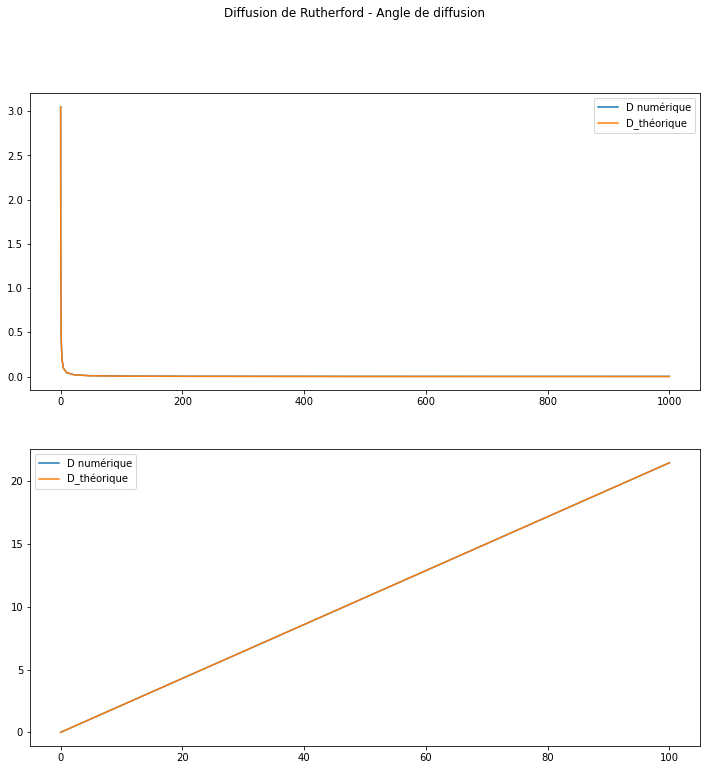

----------------
Beta théorique : 0.215
Beta numérique : 0.215
----------------


In [4]:
def D_th(b, Ec0):
    """Valeurs théoriques de l'angle de diffusion"""
    beta = 1 / (2 * Ec0) * K1
    return 2 * np.arctan(beta / b)

def D_num(Y):
    """Valeurs numériques de l'angle de diffusion"""
    theta_f = Y[-1, 0]  # Angle theta final, on considère cet angle à l'infini
    theta_i = Y[0, 0]  # Angle theta initial, on considère cet angle à l'infini
    return np.pi - (theta_f - theta_i)  # Angle de diffusion

D_ths = D_th(bs, Ec0)  # Angles de diffusion théoriques
D_nums = []  # Angles de diffusion par intégration numérique
for b in bs:
    t, Y = deviation(b, Ec0, N)  # Intégration numérique
    D_nums.append(D_num(Y))
D_nums=np.array(D_nums)  # Transformation en vecteur numpy pour manipulations
    
f, ax= plt.subplots(2, 1, figsize=(12, 12))
f.suptitle("Diffusion de Rutherford - Angle de diffusion")
ax[0].plot(bs, D_nums, label="D numérique")
ax[0].plot(bs, D_ths, label="D_théorique")
ax[0].legend()

ax[1].plot(1/bs, np.tan(D_nums / 2), label="D numérique")
ax[1].plot(1/bs, np.tan(D_ths / 2), label="D_théorique")
ax[1].legend()

plt.show()

"""
BONUS : On va faire une régression linéaire sur les valeurs numériques pour vérifier qu'on a bien
beta comme pente.
"""
beta_th = 1 / (2 * Ec0) * K1  # Valeur de pente attendue.
beta_num, o_num = np.polyfit(1/bs, np.tan(D_ths / 2), 1)
print("----------------")
print("Beta théorique : {:.3f}".format(beta_th))
print("Beta numérique : {:.3f}".format(beta_num))
print("----------------")



## Statistique des angles de diffusion
En pratique, on n'envoie pas une particule alpha mais un jet uniformément répartie dans le plan $y0z$. Pour un point de départ $(y_0, z_0)$, l'invariance par rotation autour de l'axe Ox permet de conserver l'étude précédente en prenant $b = \sqrt{y_0^2 + z_0^2}$.

Les détecteur de l'expérience de Rutherford, répartie  sur une sphère autour de l'échantillons n'ont pas accès à $D$ et $b$ mais au nombre de particules qui arrivent dans la surface $d\Omega$ (appelée _angle solide_ pour une sphère de rayon 1) située entre $D$ et $D + dD$ ($dD$ est au final la taille d'un capteur).

![Section efficace](images/section_efficace.png)

_Sur la figure, l'angle de diffusion est noté $\theta$ et non $D$._

On peut assez facilement calculer théoriquement ce nombre de particule $dn$ avec le flux de particules émis en remarquant qu'elle sont forcément passées par la surface circulaire comprise entre les rayons $b$ (angle de diffusion $D$) et $b+db$ (angle de diffusion $D +dD$) :

$$
dn = {\left(\beta \over 2\right)}^2 {1 \over \sin^4 (D/2)} Jd\Omega
$$
où 
* $J$ est le nombre de particules émis par unité de surface.
* $d\Omega = 2\pi \sin D dD$

On se propose de réaliser une simulation (de Monte-Carlo) pour vérifier l'expression théorique de la __section efficace différentielle_ :
$$
{dn \over Jd\Omega}
$$

Le principe est :
1. On tire aléatoirement (tirage uniforme) deux coordonnées $y_0$ et $z_0$. 
2. On calcule $b$ et s'il est inférieur à un $b_{max}$ fixé (on prendra $b_{max} = 100$), on déterminer l'angle de diffusion $D$ associé par intégration.
3. On détermine alors la statistique des angles de diffusion et on calcule la section efficace différentielle en fonction de $D$.

On réalisera $N = 10000$ tirages et on prendra 100 `bins` pour la statistique des angles des fréquences statistiques. De plus, on calcule $J$ par :
$$
J = N / (\pi  bmax^2)
$$

> __Exercice 4 :__  
> 1. Ecrire une fonction `tir` qui prend comme argument `Ec0`, `b_max`, `N` et `nbins` et qui renvoie les fréquences des occurences (vecteur) des angles de diffusion en respectant les règles imposées par la simulation précédente et les valeurs d'angle de diffusion associées à chaque fréquence (vecteur).
> 2. Obtenir à partir de ces deux vecteurs la section efficace différentielle en fonction $D$ et la tracé graphiquement. Tracer son expression théorique et comparer.

_Indications utiles :_  
On utilisera la fonction `histogram` de la bibliothèque `numpy` dont la signature est :

```
hist, bins = np.histogram(a, bins=Nd)
```
et qui renvoie pour un vecteur de valeurs `a` le fréquences `hist` associées aux valeurs `bins`. Le nobmre de _bacs_ de valeurs et donné par `bins`.

0


1000


2000


3000


4000


5000


6000


7000


8000
8000


9000
9000


10000


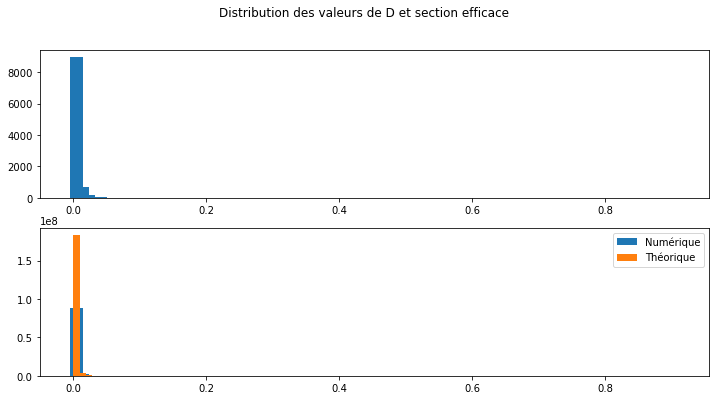

In [5]:
def tir(Ec0, bmax, N, nbins):
    Ds = []
    while len(Ds) <= N:
        if len(Ds) % 1000 == 0:
            print(len(Ds))
        YZ = rd.uniform(-bmax, bmax, 2)
        b = np.sqrt(YZ[0] ** 2 + YZ[1] ** 2)
        if b < bmax:
            t, Y = deviation(b, Ec0, N)  # Intégration numérique
            Ds.append(D_num(Y))
    hist, bins = np.histogram(Ds, bins=nbins)
    return hist, bins

N = 10000
bmax = 100
h, b = tir(Ec0, bmax, N, 100)
J = N / (np.pi * bmax**2)
db = b[1] - b[0]
h_th = (beta_th / 2) ** 2 * 1 / (np.sin(b/ 2) ** 4)


f, ax = plt.subplots(2, 1, figsize=(12, 6))
f.suptitle("Distribution des valeurs de D et section efficace")
ax[0].bar(b[:-1], h, 0.02)
ax[1].bar(b[:-1], h / (J * 2 * np.pi * np.sin(b[:-1]) * db), .02, label="Numérique")
ax[1].bar(b[:-1], h_th[:-1], .01, label="Théorique")
ax[1].legend()
plt.show()


    